# A MadMiner Example Analysis -  Analyzing dim6 operators in $W\gamma$ 

## Preparations

Let us first load all the python libraries again

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 6. Obtaining the Fisher Information using Machine Learning

Here we introduce some alternative steps which will lead us to an estimator for the score at a reference point (SALLY) and the expected Fisher information. Along the way, we'll introduce some powerful ensemble methods.

To not forget anything later, let us globaly define the number of events in the MG sample

In [2]:
lhedatafile = 'data/madminer_lhedata.h5'
nsamples = 100000

### 6a) Make (unweighted) training and test samples with augmented data

The next step is handled by the `madminer.sampling` class `SampleAugmenter`. From all the data we have in the MadMiner file now, it extracts unweighted samples including the augmented data, that is needed as training and evaluation data for the machine learning algorithms.

In [3]:
sa = SampleAugmenter(lhedatafile, debug=False)

22:24  
22:24  ------------------------------------------------------------
22:24  |                                                          |
22:24  |  MadMiner v0.1.0                                         |
22:24  |                                                          |
22:24  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
22:24  |                                                          |
22:24  ------------------------------------------------------------
22:24  
22:24  Loading data from data/madminer_lhedata.h5
22:24  Found 2 parameters:
22:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:24  Found 6 benchmarks:
22:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
22:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
22:24     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
22:24     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+01
22

The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. For the argument `theta` you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`. 

Here we are mostly interested in evaluating the Fisher Info at the SM benchmark. We will create two sets of samples, one for training and one for testing. In particular, for training we create `n_estimator` sets of samples. This will allow us later to better investigate the uncertainty of the estimates Fisher Information. 

In [4]:
#Define n_estimator
n_estimators = 5

#augment train sample
for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=int(nsamples/2),
        folder='./data/samples_ensemble/',
        filename='train{}'.format(i)
    )

#augment test sample
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=int(nsamples/2),
    folder='./data/samples_ensemble/',
    filename='test'
)

22:24  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
22:24  Effective number of samples: 50000.00000004142
22:24  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
22:24  Effective number of samples: 50000.00000004142
22:24  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
22:24  Effective number of samples: 50000.00000004142
22:24  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
22:24  Effective number of samples: 50000.00000004142
22:24  Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
22:24  Effective number of samples: 50000.00000004142
22:24  Extracting evaluation sample. Sampling according to (u'benchmark', u'sm')
22:24  Effecti

### 6b)  Train a neural network to estimate the score

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

Again, the central object for this is the `madminer.ml.MLForge` class to get a single estimator. Additionally, instead of using a single neural network to estimate the likelihood ratio, score, or Fisher information, we can use an ensemble of such estimators. That provides us with a more reliable mean prediction as well as a measure of the uncertainty. The class `madminer.ml.EnsembleForge` automates this process. Currently, it only supports SALLY estimators:

In [5]:
ensemble = EnsembleForge(estimators=n_estimators)

In particular, we can train all estimators simultaneously with `train_all()` and save the ensemble to files

In [6]:
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)]
)

ensemble.save('models/samples_ensemble')

22:24  Training 5 estimators in ensemble
22:24  Training estimator 1 / 5 in ensemble
22:24  Starting training
22:24    Method:                 sally
22:24    Training data: x at data/samples_ensemble/x_train0.npy
22:24                   t_xz (theta0) at  data/samples_ensemble/t_xz_train0.npy
22:24    Features:               all
22:24    Method:                 sally
22:24    Hidden layers:          (100, 100)
22:24    Activation function:    tanh
22:24    Batch size:             128
22:24    Trainer:                amsgrad
22:24    Epochs:                 50
22:24    Learning rate:          0.001 initially, decaying to 0.0001
22:24    Validation split:       None
22:24    Early stopping:         True
22:24    Scale inputs:           True
22:24    Shuffle labels          False
22:24    Regularization:         None
22:24  Loading training data
22:24  Found 50000 samples with 2 parameters and 26 observables
22:24  Rescaling inputs
22:24  Creating model for method sally
22:24  Training mod

### 6c)  Train a neural network with subset of observables

We can also train the EnsembleForge with just a subset of observables. This is done with the option `features`. In the following example we drop the unobservable degrees of freedom of the neutrino

In [7]:
ensemble_met = EnsembleForge(estimators=n_estimators)
ensemble_met.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
    features=(0,1,2, 3,4,5, 6,8, 9,11, 12,13,14, 15,17, 18,19,20, 23, 24,25)
)
ensemble_met.save('models/samples_metonly')


ensemble_xxx = EnsembleForge(estimators=n_estimators)
ensemble_xxx.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
    features=(0,1,2, 3,4,5, 6,8, 9,11, 12,13,14, 15,17, 18,19,20, 23)
)
ensemble_xxx.save('models/samples_xxxonly')

22:28  Training 5 estimators in ensemble
22:28  Training estimator 1 / 5 in ensemble
22:28  Starting training
22:28    Method:                 sally
22:28    Training data: x at data/samples_ensemble/x_train0.npy
22:28                   t_xz (theta0) at  data/samples_ensemble/t_xz_train0.npy
22:28    Features:               (0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 25)
22:28    Method:                 sally
22:28    Hidden layers:          (100, 100)
22:28    Activation function:    tanh
22:28    Batch size:             128
22:28    Trainer:                amsgrad
22:28    Epochs:                 50
22:28    Learning rate:          0.001 initially, decaying to 0.0001
22:28    Validation split:       None
22:28    Early stopping:         True
22:28    Scale inputs:           True
22:28    Shuffle labels          False
22:28    Regularization:         None
22:28  Loading training data
22:28  Found 50000 samples with 2 parameters and 26 observables
22:28  Res

22:32    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
22:32    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
22:32  Finished training
22:32  Training 5 estimators in ensemble
22:32  Training estimator 1 / 5 in ensemble
22:32  Starting training
22:32    Method:                 sally
22:32    Training data: x at data/samples_ensemble/x_train0.npy
22:32                   t_xz (theta0) at  data/samples_ensemble/t_xz_train0.npy
22:32    Features:               (0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23)
22:32    Method:                 sally
22:32    Hidden layers:          (100, 100)
22:32    Activation function:    tanh
22:32    Batch size:             128
22:32    Trainer:                amsgrad
22:32    Epochs:                 50
22:32    Learning rate:          0.001 initially, decaying to 0.0001
22:32    Validation split:       None
22:32    Early stopping:         True
22:32    Scale inputs:           True
22:32    Shuffle labels          False
22:32    R

22:36    Epoch 35: train loss 0.0005 (mse_score: 0.0005)
22:36    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
22:36    Epoch 45: train loss 0.0005 (mse_score: 0.0005)
22:36    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
22:36  Finished training


### 6d) Evaluate Fisher Information

Any evaluation of this ensemble will provide us with mean and variance of the predictions. Let's try that for the Fisher information: **Fix Lumi Bug**

In [8]:
fisher = FisherInformation(lhedatafile, debug=False)

fi_ml_mean, fi_ml_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_metonly_mean, fi_metonly_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_metonly',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_xxxonly_mean, fi_xxxonly_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/samples_xxxonly',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
    luminosity=300*1000./nsamples
)

fi_truth_mean, fi_truth_covariance = fisher.calculate_fisher_information_full_truth(
    theta=[0.,0.],
    luminosity=300*1000./nsamples
)

22:36  Loading data from data/madminer_lhedata.h5
22:36  Found 2 parameters:
22:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:36     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
22:36  Found 6 benchmarks:
22:36     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
22:36     w: CWL2 = 20.00, CPWL2 = 0.00e+00
22:36     morphing_basis_vector_2: CWL2 = -3.26e+01, CPWL2 = -4.46e+01
22:36     morphing_basis_vector_3: CWL2 = 8.14, CPWL2 = -3.50e+01
22:36     morphing_basis_vector_4: CWL2 = -3.51e+01, CPWL2 = 32.41
22:36     morphing_basis_vector_5: CWL2 = 5.86, CPWL2 = 39.09
22:36  Found 26 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva, m_la, mtrans, phi_resurrection
22:36  Found 100000 events
22:36  Found morphing setup with 6 components
22:36  Evaluating rate Fisher information
22:36  Found ensemble with 5 estimators an

The covariance can be propagated to the Fisher distance contour plot easily. Note that this also includes uncertainty bands corresponding to the uncertainty of the Machine Learning. This uncertainty corresponds to the standard devisation of the different ensemble constituents. 

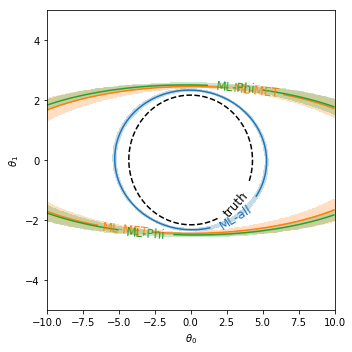

In [9]:
_ = plot_fisher_information_contours_2d(
    [fi_ml_mean, fi_metonly_mean,fi_xxxonly_mean, fi_truth_mean ],
    [fi_ml_covariance, fi_metonly_covariance,fi_xxxonly_covariance, fi_truth_covariance],
    colors=[u'C0',u'C1',u'C2',"black"],
    linestyles=["solid","solid","solid","dashed"],
    inline_labels=["ML-all","ML-MET","ML-Phi","truth"],
    xrange=(-10,10),
    yrange=(-5,5)
)